Saved comparison CSV to AzureAI_4o-mini_comparison_misclassified_tweets.csv


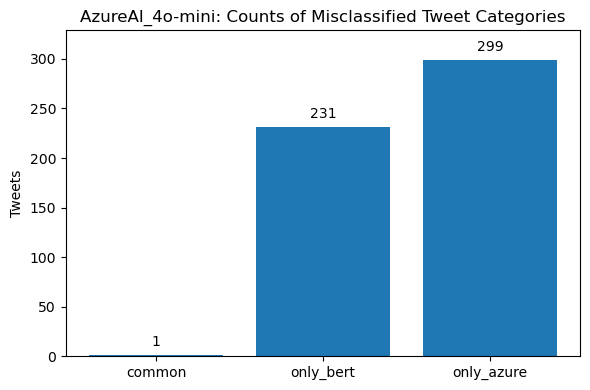

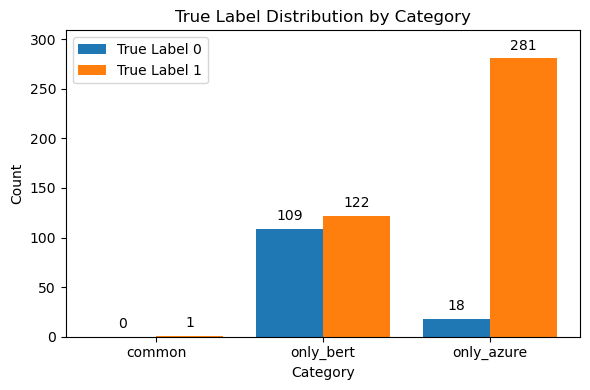

No common tweets found between BERT misclassifications and Azure error tweets.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Setup paths
current_dir         = os.path.basename(os.path.dirname(os.path.abspath("*")))
bert_path           = '../BERT_misclassified_tweets.csv'
azure_path          = f'{current_dir}_misclassified_tweets.csv'
error_tweets_path   = f'{current_dir}_error_tweets.csv'

# 2. Load data
bert_df  = pd.read_csv(bert_path)
azure_df = pd.read_csv(azure_path)
errors   = pd.read_csv(error_tweets_path)

# Normalize Azure columns
azure_df = azure_df.rename(columns={
    'Original full Tweet': 'text',
    'True label':          'true_label',
    'Predicted label':     'predicted_label'
})

# 3. Filter to true misclassifications
bert_df  = bert_df[ bert_df['predicted_label'] != bert_df['true_label'] ]
azure_df = azure_df[ azure_df['predicted_label'] != azure_df['true_label'] ]

# 4. Common vs. unique
common     = pd.merge(
    bert_df[['text','true_label','predicted_label']],
    azure_df[['text','predicted_label']],
    on='text',
    suffixes=('_bert','_azure')
).assign(category='common')

only_bert  = bert_df[ ~bert_df['text'].isin(azure_df['text']) ].copy().assign(category='only_bert')
only_azure = azure_df[~azure_df['text'].isin(bert_df['text']) ].copy().assign(category='only_azure')

# 5. Build & save comparison CSV
all_texts = sorted(set(bert_df['text']).union(azure_df['text']))
cmp = pd.DataFrame({'text': all_texts})

b_small = (bert_df[['text','true_label','predicted_label']]
           .drop_duplicates('text')
           .rename(columns={
               'true_label':      'true_label_bert',
               'predicted_label': 'predicted_label_bert'
           }))
a_small = (azure_df[['text','true_label','predicted_label']]
           .drop_duplicates('text')
           .rename(columns={
               'true_label':      'true_label_azure',
               'predicted_label': 'predicted_label_azure'
           }))

cmp = cmp.merge(b_small, on='text', how='left')
cmp = cmp.merge(a_small, on='text', how='left')
cmp['true_label'] = cmp['true_label_bert'].combine_first(cmp['true_label_azure'])
cmp = cmp.drop(columns=['true_label_bert','true_label_azure'])

out_csv = f'{current_dir}_comparison_misclassified_tweets.csv'
cmp.to_csv(out_csv, index=False)
print(f"Saved comparison CSV to {out_csv}")

# 6. Plot counts, in fixed order
category_order = ['common','only_bert','only_azure']
counts = {
    'common':     len(common),
    'only_bert':  len(only_bert),
    'only_azure': len(only_azure),
}

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(category_order, [counts[c] for c in category_order])
ax.set_title(f'{current_dir}: Counts of Misclassified Tweet Categories')
ax.set_ylabel('Tweets')
ax.set_ylim(0, max(counts.values()) * 1.1)

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        h + max(counts.values())*0.02,
        f'{int(h)}',
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.savefig(f"{current_dir}_Bert_Compare.png")
plt.show()

# 7. Plot true‐label distribution, same order
cat_df = pd.concat([common, only_bert, only_azure], ignore_index=True)
dist   = cat_df.groupby(['category','true_label']).size().unstack(fill_value=0)
dist   = dist.reindex(category_order)  # enforce order

x = np.arange(len(category_order))
fig, ax = plt.subplots(figsize=(6,4))
bar0 = ax.bar(x - 0.2, dist[0], width=0.4, label='True Label 0')
bar1 = ax.bar(x + 0.2, dist[1], width=0.4, label='True Label 1')
ax.set_xticks(x)
ax.set_xticklabels(category_order)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('True Label Distribution by Category')
ax.legend()
ax.set_ylim(0, dist.values.max()*1.1)

for group in (bar0, bar1):
    for bar in group:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            h + dist.values.max()*0.02,
            f'{int(h)}',
            ha='center', va='bottom'
        )

plt.tight_layout()
plt.savefig(f"{current_dir}_TrueLabel_Distribution.png")
plt.show()

# 8. ERROR-TWEETS ANALYSIS
errors    = pd.read_csv(error_tweets_path)

# 3. Normalize columns
azure_df = azure_df.rename(columns={
    'Original full Tweet': 'text',
    'True label':          'true_label',
    'Predicted label':     'predicted_label'
})
errors = errors.rename(columns={
    'Original tweet':    'text',
    'True class':        'true_label_error',
    'Violation reasons': 'error_reason',
    'Severity label':    'severity_label'
})

# 4. Filter to misclassifications
bert_df   = bert_df[bert_df['predicted_label']  != bert_df['true_label']]
azure_df  = azure_df[azure_df['predicted_label'] != azure_df['true_label']]

# 5. Identify only-BERT misclassifications
only_bert = bert_df[~bert_df['text'].isin(azure_df['text'])].copy()

# 6. Find overlap with error tweets
error_only_bert = only_bert.merge(
    errors[['text','true_label_error','error_reason','severity_label']],
    on='text', how='inner'
)

# 7. Conditional message if no overlap
if error_only_bert.empty:
    print("No common tweets found between BERT misclassifications and Azure error tweets.")
else:
    print(f"Found {len(error_only_bert)} BERT misclassifications that failed in Azure.")
    err_csv = os.path.join(f'{current_dir}_only_bert_error_tweets.csv')
    error_only_bert[['text','true_label_error','error_reason','severity_label']].to_csv(err_csv, index=False)
    print(f"Saved only-BERT error tweets to {err_csv}")

